# [Extra A] Tutorial 1 - Text Mining
## Word Embedding

- Nama: Muhammad Ichsanul Amal
- NPM: 1906353454

Tutorial ini merupakan tambahan untuk mereview beberapa teknik yang lebih baru untuk melakukan Text Mining. Terdapat dua pembahasan yang dicakup dalam tutorial ini, yaitu Word Embedding dan Transformer-based Language Model. Penjelasannya akan dibahas berikutnya. 

Transformer-based Language Model dibahas di notebook terpisah dan dapat dieksplorasi secara mandiri bagi yang tertarik pada topik tersebut. 

Link Notebook Transformer: https://colab.research.google.com/drive/1dZr7haRjTn86swq-L8oETB74hWqp6A9v?usp=sharing

In [5]:
!pip install --upgrade gdown --quiet

In [6]:
import numpy as np
import pandas as pd
import random
import gdown
import nltk

from tqdm import tqdm

# Word2Vec Gensim
import gensim
from gensim.models import Word2Vec

from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Kita akan menggunakan dataset yang sama seperti pada Tutorial sebelumnya, yaitu Deteksi Emosi pada Twitter Indonesia.

In [7]:
# TO DO: Upload dataset terlebih dahulu ke Colab
# Alternatifnya, file dataset bisa diunggah ke drive terlebih dahulu lalu lakukan 
# mounting drive ke Colab

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Twitter_Emotion_Dataset.csv')
df.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


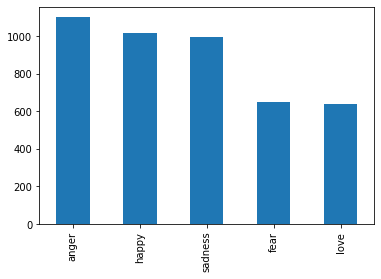

In [9]:
df['label'].value_counts().plot(kind='bar')

## 1. Word Vector/Word Embedding

Word Vector merupakan konsep untuk memetakan setiap kata ke sebuah vektor berdimensi tinggi.

$$f:W \to (x_1, x_2, ...,x_m) $$

Salah satu kelebihan Word Vector dibandingkan dengan representasi berbasis $n$-gram (Bag of Words dan TF-IDF) adalah kemampuan untuk memetakan kata-kata yang memiliki makna serupa (sinonim) atau berlawanan (antonim). Kemampuan itu didukung dengan ukuran *vector similarity* antara kedua kata.

Contohnya yaitu seperti pada gambar di bawah ini. Kata '*beautiful*' dan '*appealing*' memiliki makna yang serupa, sementara '*dull*' memiliki makna yang cukup berlawanan.

Jika tertarik untuk mempelajari lebih lanjut:
- https://dzone.com/articles/introduction-to-word-vectors
- Original paper: https://arxiv.org/abs/1301.3781

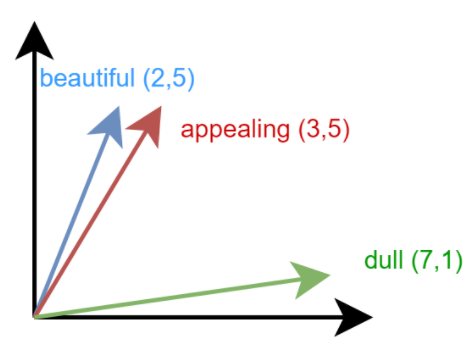

Untuk kasus ini, kita akan coba menggunakan model Word2Vec (salah satu library untuk Word Vector) yang sudah dilatih (*pre-trained*). Model ini tersedia di https://github.com/deryrahman/word2vec-bahasa-indonesia

Model ini dilatih pada kumpulan artikel Wikipedia Bahasa Indonesia.

Terdapat 3 variasi dimensi vektor, yaitu 100, 200, dan 300. Pertama, kita akan coba menggunakan yang terkecil.

Referensi artikel: https://medium.com/@diekanugraha/membuat-model-word2vec-bahasa-indonesia-dari-wikipedia-menggunakan-gensim-e5745b98714d

In [10]:
# word2vec length 100
!gdown --id 1lmZuikAJ5t69lZMvx4iKfnsMDS9UI3HB

# word2vec length 300
!gdown --id 1X5ZPsaoXFxJFrcJ7pVkV9VC81lmDIzdI

!unzip idwiki_word2vec_100.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1lmZuikAJ5t69lZMvx4iKfnsMDS9UI3HB
To: /content/idwiki_word2vec_100.zip
100% 253M/253M [00:01<00:00, 134MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1X5ZPsaoXFxJFrcJ7pVkV9VC81lmDIzdI
To: /content/idwiki_word2vec_300.zip
100% 746M/746M [00:24<00:00, 31.0MB/s]
Archive:  idwiki_word2vec_100.zip
  inflating: idwiki_word2vec_100.model.wv.vectors.npy  
  inflating: idwiki_word2vec_100.model.trainables.syn1neg.npy  
  inflating: idwiki_word2vec_100.model  


In [22]:
!unzip idwiki_word2vec_300.zip

Archive:  idwiki_word2vec_300.zip
  inflating: idwiki_word2vec_300.model.trainables.syn1neg.npy  
  inflating: idwiki_word2vec_300.model.wv.vectors.npy  
  inflating: idwiki_word2vec_300.model  


### 1a. Menggunakan Model Word2Vec

Selanjutnya, kita coba input model yang sudah didownload sebelumnya. Library yang digunakan adalah library [Gensim](https://radimrehurek.com/gensim/).

In [11]:
w2v_model = gensim.models.Word2Vec.load("idwiki_word2vec_100.model")

Kita bisa mengambil salah satu kata (misalnya: "pesawat") untuk mencoba mendapatkan vektornya. Karena vektor tersebut cukup panjang, kita coba ambil 10 dimensi pertamanya saja.

In [12]:
# Contoh Word Vector

print("Embedding kata 'pesawat'")
print("10 dim pertama:", w2v_model.wv['pesawat'][:10])
print("Jumlah dimensi:", w2v_model.wv['pesawat'].shape)

Embedding kata 'pesawat'
10 dim pertama: [-0.89698255  2.2322412   2.1836152  -4.8095484   0.6571641   3.0960891
  0.48786417 -4.6133084  -4.789883   -2.1193895 ]
Jumlah dimensi: (100,)


**Dense vs Sparse Vector**

Jika Anda memperhatikan hasil embeddingnya, terdapat perbedaan karakteristik vektor yang dihasilkan antara vektor $n$-gram-based (Bow dan TF-IDF) dengan vektor word embedding. 

$n$-gram-based memiliki output vektor yang bersifat ***sparse***, di mana banyak elemen vektor yang bernilai 0. Hal ini dikarenakan satu vektor dokumen merepresentasikan kemunculan term pada dokumen tersebut.

Misalkan, terdapat **2.000 tweet** dengan rata-rata kata per tweet sebanyak **20 kata**. Pada *worst case scenario*, masing-masing *tweet* tidak memiliki kata berulang dan 2.000 tweet tersebut tidak mengandung kata yang sama, maka terdapat **40.000 kata** unik dengan hanya 20 di antaranya yang tidak bernilai 0 untuk masing-masing tweet.

<div align='center'>
  <img src='https://drive.google.com/uc?id=1ioy0fR42ThwqjTJ2L6AWemibPW2yuMVz' width='500'/><br>
  Ilustrasi $n$-gram-based vector
</div>

Di sisi lain, word embedding memiliki output vektor yang bersifat ***dense***, di mana hampir tidak ada elemen di dalam vektor yang bernilai nol. 

Hal ini membuat representasi word embedding mudah untuk mengukur *similarity* antar vektor, karena tidak banyak *noise* elemen 0 yang timbul sebagai akibat dari *sparse vector*.

Kita juga bisa memetakan seberapa mirip sebuah pasang kata. Misalnya pada contoh berikut, `pesawat-kereta` memiliki similarity yang sedang sebagai sesama kendaraan. Sementara itu, `komputer-ponsel` memiliki similarity yang cukup tinggi. Namun, pasangan kata yang berlawanan seperti `senyap-ramai` memiliki nilai similarity yang lebih rendah.

In [13]:
# Contoh similarity

print("(pesawat, kereta) =", w2v_model.wv.similarity('pesawat', 'kereta'))
print("(komputer, ponsel) =", w2v_model.wv.similarity('komputer', 'ponsel'))
print("(senyap, ramai) =", w2v_model.wv.similarity('senyap', 'ramai'))

(pesawat, kereta) = 0.5023877
(komputer, ponsel) = 0.69093394
(senyap, ramai) = 0.24767166


Salah satu kekurangan dari Word2Vec adalah tidak bisa memahami kata yang belum pernah dilatih. Misalnya, karena model ini dilatih sebelum pandemi COVID-19, maka model ini tidak bisa memetakan kata `covid` ke dalam vektor.

In [14]:
# Contoh missing value

try:
  print(w2v_model.wv['covid'])
except KeyError as e:
  print("Error:", e)

Error: "word 'covid' not in vocabulary"


### 1b. Transformasi Teks ke Vektor

Selanjutnya, kita akan mentransformasi teks tweet pada dataset menjadi representasi vektor. Tahapan pengolahannya adalah sebagai berikut:

1. **Preprocessing**. Tahap ini pada dasarnya hanya melakukan *lowercasing* dan *tokenization*. Kata-kata yang terdapat dalam vocabulary model Word2Vec sebelumnya merupakan kata-kata yang telah di-*lowercasing*.

2. **Transformation**. Selanjutnya, dilakukan konversi setiap kata ke vektor. Lalu setiap vektor yang ada di dalam tweet dilakukan *average pooling* untuk menyeragamkan dimensi vektor untuk masing-masing tweet.

In [15]:
tweet_tokenizer = nltk.TweetTokenizer()

def preprocessing_and_tokenize(tweet):
  tweet = tweet.lower()
  tokens = tweet_tokenizer.tokenize(tweet)
  return tokens

def convert_w2v(tweet):
  word_vectors = []
  for w in preprocessing_and_tokenize(tweet):
    try:
      v = w2v_model.wv[w]
      word_vectors.append(v)
    except KeyError:
      continue
  return np.array(word_vectors).mean(axis=0)

In [16]:
X = []

for _,tweet in tqdm(df['tweet'].iteritems()):
  vector = convert_w2v(tweet)

  # Jika size vector tidak sesuai karena missing data, akan direplace dengan vektor nol
  if (vector.shape != (w2v_model.vector_size,)):
    vector = np.zeros((w2v_model.vector_size,))

  X.append(vector)

X = np.array(X)
X.shape

4401it [00:00, 4523.46it/s]


(4401, 100)

### 1c. Klasifikasi

Terakhir, kita akan menggunakan fitur Word2Vec untuk melakukan klasifikasi emosi. Untuk proses ini, kita lakukan splitting dataset menjadi train set dan test set.

Model yang digunakan adalah Support Vector Machine (SVM). 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, df['label'].to_list(), 
                                                    test_size = 0.2,
                                                    random_state = 2022)

print("X Train Shape:", X_train.shape)

X Train Shape: (3520, 100)


In [18]:
svm_classifier = SVC(kernel='linear')

svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.57      0.67      0.61       217
        fear       0.54      0.43      0.48       126
       happy       0.53      0.50      0.51       204
        love       0.71      0.66      0.69       147
     sadness       0.42      0.44      0.43       187

    accuracy                           0.55       881
   macro avg       0.55      0.54      0.54       881
weighted avg       0.55      0.55      0.54       881



Jika kita lakukan evaluasi, hasil Macro-Average F1-Score masih lebih rendah dibandingkan dengan performa dari TF-IDF. Hal ini terjadi karena adanya perbedaan domain dataset yang digunakan pada saat melatih model Word2Vec dengan dataset yang kita gunakan.

Jika Anda coba baca dokumentasi dari *author* yang merilis model Word2Vec Bahasa Indonesia (cek referensi), maka Anda mengetahui kalau model ini dilatih pada dataset Wikipedia, di mana penulisannya secara umum ditulis dalam bahasa formal. Sementara itu dataset yang kita miliki merupakan dataset Twitter, di mana  penulisannya mayoritas bukan penulisan baku (misal: "*gw*", "*haiiii*", "*jln jatibaru*").

****
Referensi artikel: https://medium.com/@diekanugraha/membuat-model-word2vec-bahasa-indonesia-dari-wikipedia-menggunakan-gensim-e5745b98714d

## Soal [BONUS]

1. Lakukan eksperimen dengan model classifier lainnya. Anda bisa merujuk ke dokumentasi `scikit-learn`.
2. Gunakan Word2Vec dengan dimensi 300. Apakah terdapat perbedaan skor? Berikan penjelasan.

In [19]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
NN.fit(X_train, y_train)
y_pred = NN.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.53      0.69      0.60       217
        fear       0.00      0.00      0.00       126
       happy       0.33      0.28      0.31       204
        love       0.60      0.63      0.61       147
     sadness       0.28      0.40      0.33       187

    accuracy                           0.42       881
   macro avg       0.35      0.40      0.37       881
weighted avg       0.37      0.42      0.39       881



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

In [20]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.37      0.83      0.51       217
        fear       0.00      0.00      0.00       126
       happy       0.55      0.32      0.40       204
        love       0.58      0.41      0.48       147
     sadness       0.30      0.28      0.29       187

    accuracy                           0.41       881
   macro avg       0.36      0.37      0.34       881
weighted avg       0.38      0.41      0.36       881



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
w2v_model = gensim.models.Word2Vec.load("idwiki_word2vec_300.model")

In [24]:
X = []

for _,tweet in tqdm(df['tweet'].iteritems()):
  vector = convert_w2v(tweet)

  # Jika size vector tidak sesuai karena missing data, akan direplace dengan vektor nol
  if (vector.shape != (w2v_model.vector_size,)):
    vector = np.zeros((w2v_model.vector_size,))

  X.append(vector)

X = np.array(X)
X.shape

4401it [00:01, 3936.91it/s]


(4401, 300)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, df['label'].to_list(), 
                                                    test_size = 0.2,
                                                    random_state = 2022)

print("X Train Shape:", X_train.shape)

X Train Shape: (3520, 300)


In [26]:
svm_classifier = SVC(kernel='linear')

svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.61      0.71      0.66       217
        fear       0.59      0.52      0.56       126
       happy       0.56      0.56      0.56       204
        love       0.70      0.68      0.69       147
     sadness       0.46      0.43      0.44       187

    accuracy                           0.58       881
   macro avg       0.59      0.58      0.58       881
weighted avg       0.58      0.58      0.58       881



Ya, skor akurasi dan rata-rata macro maupun weighted nya lebih tinggi pada dimensi lebih tinggi. 

Penjelasan lebih lanjutnya sejujurnya saya kurang mengerti, tetapi terdapat jawaban dari https://stackoverflow.com/questions/26569299/word2vec-number-of-dimensions